# Лабораторная работа 4

## Задание 1. PyTorch для автоматического вычисления градиента

In [153]:
import torch
import numpy as np

#####
1. PyTorch предоставляет структуру данных Tensor, которая очень похожа на Numpy nndaray.
2. Разбивает вычисления на части, которые считаются последовательно(представляется это ввиде динамического графа, где каждая вершина независимый код, обрабатывающий свою операцию). Все сложные вычисления происходят на С/С++
3. Каждый torch.Tensor содержит компоненты:
 3.1 grad (значение градиента) или
 3.2 grad_fn(ссылка на функцию вычисления градиента)

### autograd

##### Если для тензора нужно вычислить градиент, тогда requires_grad нужно присвоить значение True, по умолчанию False. Создается динамический граф, в котором автоматически создаются обратные функции, и при вызове .backward() запустится проход по графу в обратную сторону и сосчитается grad

In [154]:
x = torch.randn(3, requires_grad=True)
print(x)
y = x*5
print(y)

z = y.mean()
print(z)

z.backward()
print(x.grad)

tensor([-0.2685, -0.2917,  2.1003], requires_grad=True)
tensor([-1.3427, -1.4587, 10.5016], grad_fn=<MulBackward0>)
tensor(2.5667, grad_fn=<MeanBackward0>)
tensor([1.6667, 1.6667, 1.6667])


#### Для вектора.

In [155]:
x = torch.ones(3, requires_grad=True)
print(x)
y = x*5
print(y)

g = y+4
print(g)

g.backward(torch.ones_like(g))
print(x.grad)

tensor([1., 1., 1.], requires_grad=True)
tensor([5., 5., 5.], grad_fn=<MulBackward0>)
tensor([9., 9., 9.], grad_fn=<AddBackward0>)
tensor([5., 5., 5.])


### grad

In [156]:
# f(x) = x^2
a = (torch.tensor([-2., -1., 1., 4.]),)
b = torch.tensor([4., 1., 1., 16.], )
torch.gradient(b, spacing=a)

(tensor([-3., -2.,  2.,  5.]),)

In [157]:
b = torch.tensor([2., 1., 1., 0.], )
torch.gradient(b, spacing=2)

(tensor([-0.5000, -0.2500, -0.2500, -0.5000]),)

### Autogradient for previous task

In [158]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

# helpers
f_calls_counter = 0
grad_calls_counter = 0
cur_lr = 0

def get_min_by_f(f, eps, lr, x, start_lr = 0.1) :
    global cur_lr
    cur_lr = start_lr
    points = np.asarray([])
    counter = 0
    next = next_x(x, lr, f, counter)
    while LA.norm(next - x) > eps:
        counter += 1
        points = np.append(points, x)
        x = next
        next = next_x(x, lr, f, counter, eps)
    return [x, counter, points]

# multidimension function in point [x_0, ..., x_n]
def f(x):
    a = x[0]
    return a**2 + 5*a + 10  

def next_x(x, lr, f, epoch = 0, eps = 0.0001) : 
    global cur_lr 
    cur_lr = lr(cur_lr, epoch)
    return x - cur_lr * grad(x, f, eps)    

def grad(x, f, eps):
        derivative = np.zeros(np.size(x))
        for i in range(np.size(x)):
            x[i] += eps
            f1 = f(x)
            x[i] -= 2 * eps
            f2 = f(x)
            x[i] += eps
            derivative[i] = (f1 - f2) / (2 * eps)
        return derivative   

  


#### Numpy градиентный спуск

In [159]:
import time

    
start_time = time.time()    
answer = get_min_by_f(f, 1e-6, (lambda lr, epoch: 0.16), np.asarray([7.0]))
print(" %s seconds" % (time.time() - start_time))
print("epoch: ", answer[1])
print("min :", answer[0])   
print("f(x):", f(answer[0])) 

 0.002000093460083008 seconds
epoch:  39
min : [-2.49999721]
f(x): 3.750000000007783


#### Pytorch градиентный спуск

In [160]:
def torch_gd(f, eps, lr, x_, start_lr = 0.16, max_epoch=1000):
    points = np.zeros((max_epoch, 1))
    x = [x_]
    points[0] = x[0].detach().numpy()
    cur_lr = start_lr
    i=0
    while i<max_epoch-1:
        i += 1
        t = f(x[-1])
        t.backward()
        cur_lr = lr(cur_lr, 0)
        points[i] = x[-1].detach().numpy() - cur_lr * x[-1].grad.numpy()
        x.append(torch.tensor(points[i], requires_grad=True))
        if (LA.norm(points[i]-points[i-1])<eps): break
    return [x, i, points]  


In [161]:
start = time.time()    
answer = torch_gd(f, 1e-6, (lambda lr, epoch: 0.16), x_=torch.tensor([7.0], requires_grad=True))
print(" %s seconds" % (time.time() - start))
print("epoch: ", answer[1])
print("min :", answer[0][answer[1]])  
print("f(x):", f(answer[0][answer[1]]))

 0.009000539779663086 seconds
epoch:  40
min : tensor([-2.5000], dtype=torch.float64, requires_grad=True)
f(x): tensor(3.7500, dtype=torch.float64, grad_fn=<AddBackward0>)


# Задание 2. Использование вариантов SGD (torch.optim) из PyTorch.

In [162]:
import torch
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA
plt.rcParams["figure.figsize"] = (10, 5)

### custom SGD

In [163]:
DEFAULT_LR = 0.01
njev = 0
nfev = 0

constant_lr = (lambda current_lr, epoch: DEFAULT_LR)

def step_decay(lr, epoch, epochs_drop = 20, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))

In [164]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, delta = 0.):
    return np.sum(coefficients * x) + delta

class point_set:
    def __init__(self, n, dim, x, y, coefficients, delta, coords_bound = 0.):
        self.n = n
        self.dim = dim
        self.x = np.asarray(x, dtype=np.float64)
        self.y = np.asarray(y, dtype=np.float64)
        self.coefficients = coefficients
        self.delta = delta
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    delta = np.asarray([0] * n)
    for i in range(0, n):
        delta[i] = coefficients_bound * (2 * np.random.random_sample() - 1)
        y = np.append(y, f(coefficients, x[i], delta[i]))
    return point_set(n, dim, x, y, coefficients, delta, coords_bound)


EPOCH_MAX = 500
input_2d = create_point_set(200, 2, 20., 10.)
input_large = create_point_set(200, 10, 20., 10.)

In [165]:
def loss_function(points, coeffs, i):
    return 1 / (points.n) * np.square(coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1] * points.x[i]) - points.y[i]) 

def apply_all_loss_functions(points, coeffs):
    result = 0.
    for i in range(0, points.dim):
        result += loss_function(points, coeffs, i)
    return result

In [166]:
def gradient_compute(points, coeffs, id, h=1e-5):
    dim = points.dim
    grad = np.asarray([0.] * dim)
    step = np.asarray([0.] * dim)
    for i in range(0, dim):
        step[i] = h
        grad[i] = (loss_function(points, coeffs + step, id) - loss_function(points, coeffs - step, id)) / (2 * h)
        step[i] = 0.
    return grad

def loss_function_grad(points, ids, coeffs):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs, i)
    return result

In [167]:
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, _param_1, _param_2):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * np.asarray(grad)
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [168]:
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, param_2):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + (1 - betta) * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [169]:
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs - betta * grad, i)
    return result

def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0

    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        coeffs = coeffs_step
        loss_history.append(apply_all_loss_functions(points, coeffs))

        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [170]:
def adagrad(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v + np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5)) * current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [171]:
def rms_prop(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v * betta + (1 - betta) * np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5)) * current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [172]:
def adam(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    prev_grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    epsilon = np.asarray([0.01] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        
        grad_current = betta * prev_grad + (1-betta) * grad
        v = prev_v*gamma + (1-gamma)*np.power(grad, 2)

        coeffs_step = coeffs - np.divide(grad_current, (np.power(v, 0.5) + epsilon))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        prev_grad = grad_current
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]


### torch.optim SGD

In [173]:
def Linear_to_array(model):
    return np.append(model.weight.detach().numpy()[0], model.bias.detach().numpy()[0])

In [174]:
def linear_regression(coeffs, points):
    y = np.asarray([0.] * points.n)
    for i in range(0, points.n):
        y[i] = coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1].detach().numpy() * points.x[i])
    return torch.tensor(y, requires_grad=True)

# points - point_set instance
def torch_sgd(points, model, optimizer, scheduler, eps):
    xs = torch.tensor(points.x, requires_grad=True).float()
    ys = torch.tensor(np.asarray([points.y]).T).float()

    loss_history = list()
    error_history = list()
    total_epoches = 0
    
    previous_coeffs = np.zeros(points.dim)

    for epoch in range(0, EPOCH_MAX):
        coeffs = model(xs)
        loss = torch.nn.functional.mse_loss(coeffs, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        current_coeffs = Linear_to_array(model)
        if LA.norm(current_coeffs - previous_coeffs) <= eps:
            break
        
        previous_coeffs = current_coeffs

        total_epoches += 1
        loss_history.append(float(loss) / points.n)
        
    return [Linear_to_array(model), total_epoches, loss_history]
        

### tests 

In [175]:
def draw_2d_result(points, result):
    plt.plot(points.x, points.y, 'o', markersize=1)
    grid = np.linspace(np.min(points.x), np.max(points.x), 1000)
    plt.title('Point set and evaluated function')
    plt.plot(grid, result[0][0] * grid + result[0][1])
    plt.show()

def print_result(points, result, tittle=''):
    print(tittle, "sgd result:")
    print("coeffs:", result[0])
    print("epoches:", result[1])
    print("loss:", result[2][-1])
    
    if points.dim == 2:
        draw_2d_result(points, result)

    print('\n')

def draw_loss(custom_result, result):
    plt.plot(custom_result, label='custom loss')
    plt.plot(result, label='torch loss')
    plt.grid()
    plt.legend()
    plt.show()


In [176]:
def compare_sgd(points, optimizer_getter, custom_gd, current_lr, eps = 1e-6, param_1 = 0, param_2 = 0):

    model = torch.nn.Linear(points.dim - 1, 1)
    starting_coeffs = Linear_to_array(model)

    optimizer = optimizer_getter(model)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.5)
    
    custom_result = custom_gd(points, points.n * 2 // 5, loss_function_grad, starting_coeffs, step_decay, current_lr, eps, EPOCH_MAX, param_1, param_2)    
    result = torch_sgd(points, model, optimizer, scheduler, eps)

    print_result(points, custom_result, 'custom')
    print_result(points, result, 'torch')
    draw_loss(custom_result[2], result[2])

#### SGD

custom sgd result:
coeffs: [-7.98033628 -0.90167507]
epoches: 32
loss: 0.06937444888204533


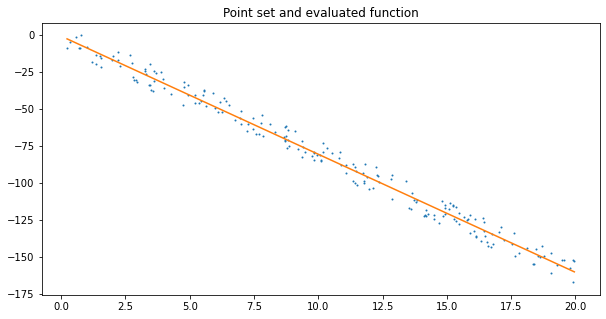



torch sgd result:
coeffs: [-7.9114575 -0.8970131]
epoches: 36
loss: 0.1492709732055664


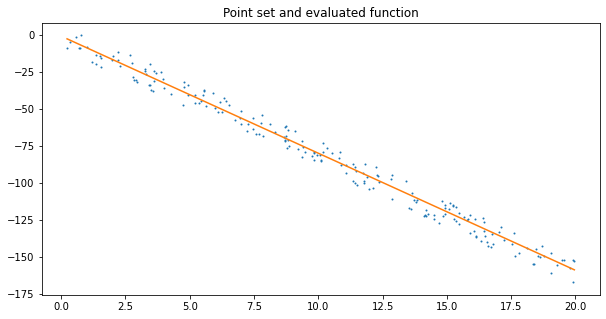

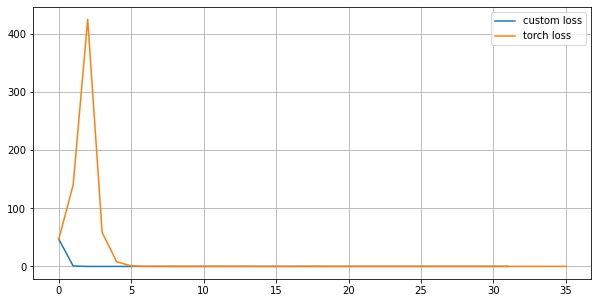

===large input===

custom sgd result:
coeffs: [-7.63329162 -5.80359562 -7.57657661 -5.55108751 -7.41293031 -6.89084686
 -6.91806356 -7.67999388 -6.90891826 -0.76288984]
epoches: 35
loss: 88.2230964672716


torch sgd result:
coeffs: [-7.3003516 -6.1609178 -7.582674  -6.0170918 -7.392603  -6.782111
 -7.068454  -7.25624   -6.676661  -0.7723442]
epoches: 38
loss: 7.55093994140625




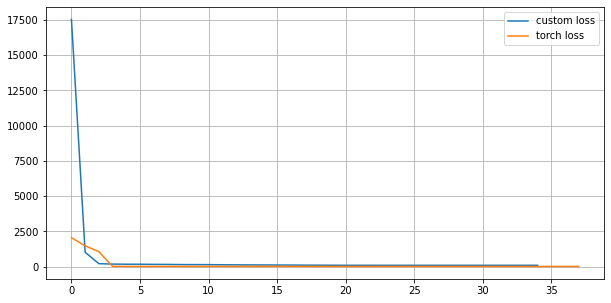

In [177]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR), sgd, DEFAULT_LR)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=0.001), sgd, 0.001)

#### SGD with momentum

custom sgd result:
coeffs: [-7.95085523 -1.38905512]
epoches: 31
loss: 0.08421397278468133


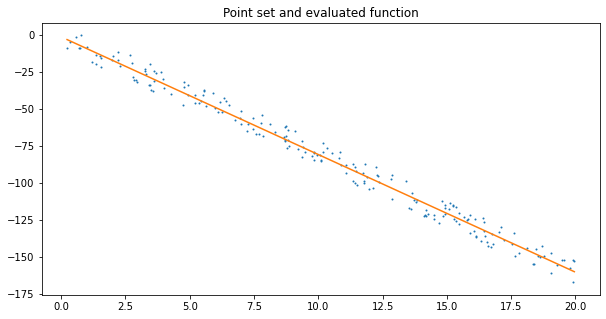



torch sgd result:
coeffs: [-7.4538136 -1.3361682]
epoches: 44
loss: 0.3132263374328613


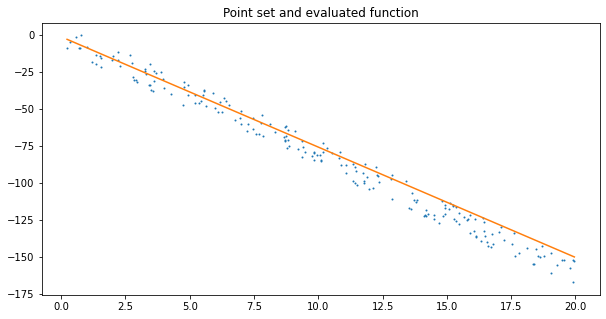

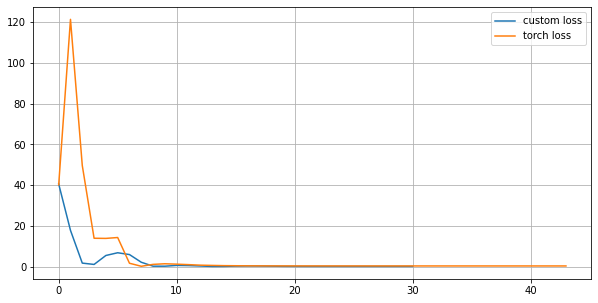

===large input===

custom sgd result:
coeffs: [-9.92195507 -1.45692074 -9.73461758 -1.90922737 -7.88290323 -6.71990507
 -5.0645597  -8.78060457 -8.86457719 -0.88957925]
epoches: 40
loss: 45.081548854633766


torch sgd result:
coeffs: [-43564.844  -47258.066  -46485.31   -44608.734  -46705.715  -41911.37
 -47474.344  -42894.754  -38870.3     -4309.9985]
epoches: 64
loss: 82367359221.76




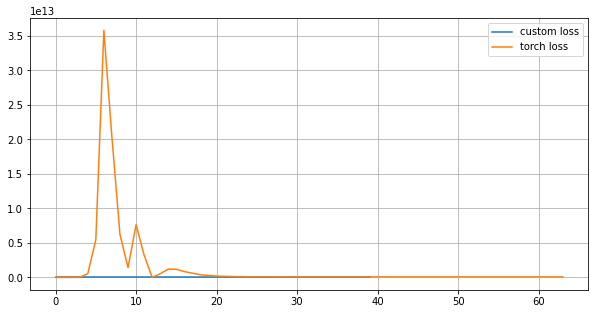

In [178]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.7), sgd_with_momentum, DEFAULT_LR, param_1=0.7)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.8), sgd_with_momentum, DEFAULT_LR, param_1=0.8)

#### SGD with Nesterov momentum

custom sgd result:
coeffs: [-8.02068803 -0.67087813]
epoches: 48
loss: 0.07064791582322992


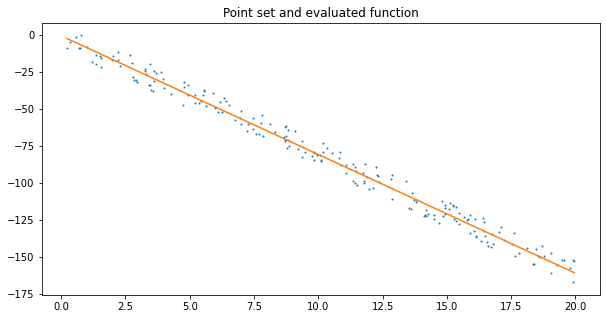



torch sgd result:
coeffs: [-8.089566   -0.65058124]
epoches: 40
loss: 0.15126103401184082


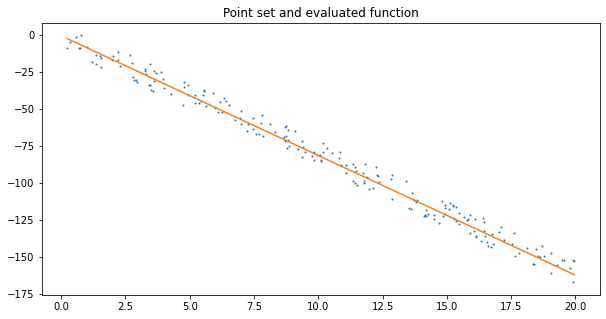

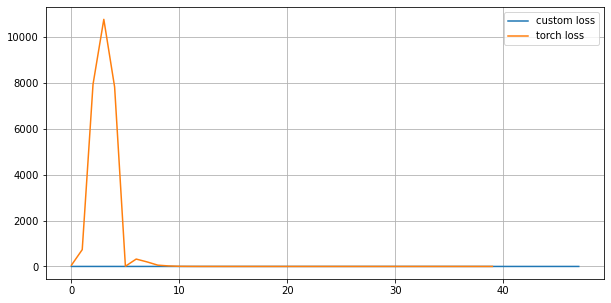

===large input===

custom sgd result:
coeffs: [ -9.08499107  -1.1441907   -8.67516078   1.25387785  -9.10822048
  -8.35776176  -6.16131641 -11.16556619 -10.76825194  -0.74703863]
epoches: 143
loss: 53.368541219803944


torch sgd result:
coeffs: [-7.971472   -3.6291475  -7.960405   -3.9168127  -7.7598963  -6.9655905
 -6.0808024  -8.734908   -7.4622717  -0.77672493]
epoches: 50
loss: 4.166158142089844




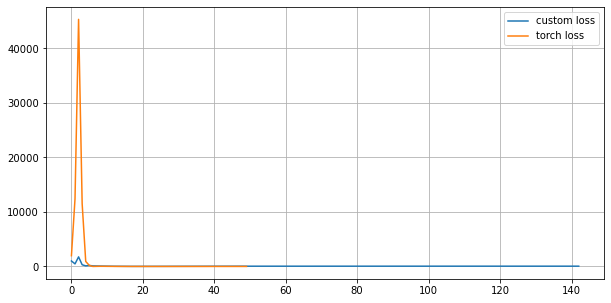

In [179]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.7, nesterov=True), sgd_with_nesterov_momentum, DEFAULT_LR, param_1=0.7)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True), sgd_with_nesterov_momentum, 0.001, param_1=0.9)


#### Adagrad

custom sgd result:
coeffs: [-7.26417917 -7.26647222]
epoches: 32
loss: 0.2124631737627875


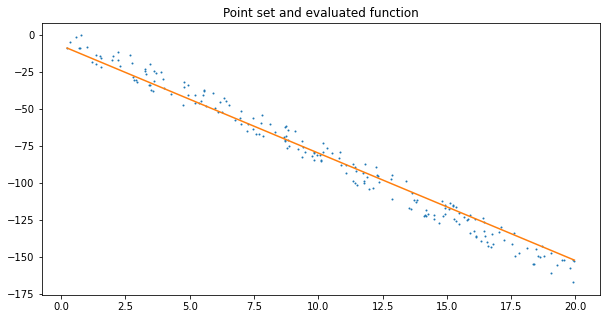



torch sgd result:
coeffs: [-4.460495 -4.781538]
epoches: 38
loss: 7.263074340820313


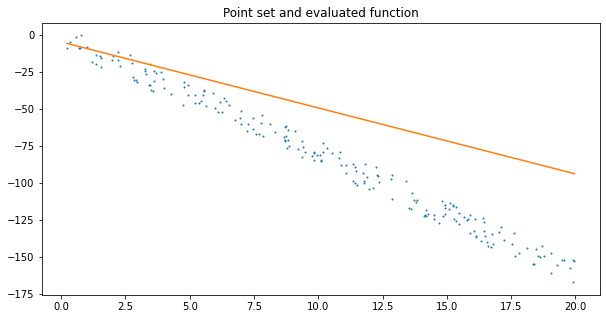

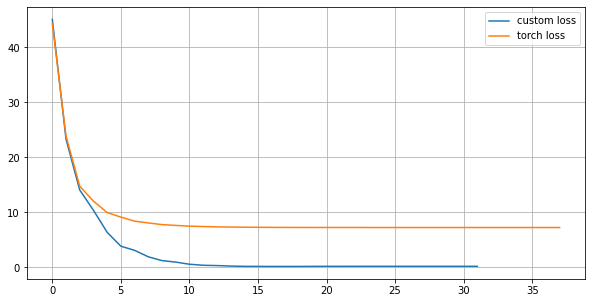

===large input===

custom sgd result:
coeffs: [-6.41529062 -6.20755409 -6.44784581 -6.38852246 -6.39011835 -6.44643074
 -6.30082578 -6.43916903 -6.42114215 -6.45520015]
epoches: 35
loss: 202.42349597593872


torch sgd result:
coeffs: [-3.5504723 -3.7667942 -3.5462978 -3.7422554 -3.6919134 -3.7188096
 -3.4669092 -3.6549954 -3.680191  -3.7178838]
epoches: 40
loss: 446.842265625




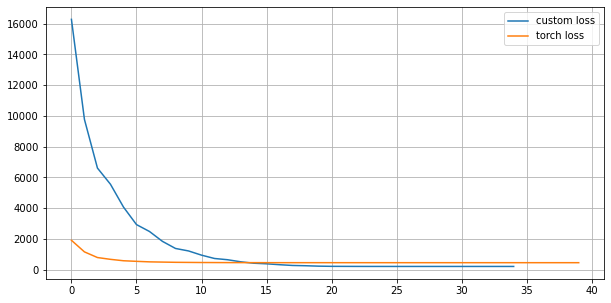

In [180]:
compare_sgd(input_2d, lambda model: torch.optim.Adagrad(model.parameters(), lr=2), adagrad, 2)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.Adagrad(model.parameters(), lr=1.5), adagrad, 1.5)

#### RMS Prop

custom sgd result:
coeffs: [-7.64277448 -5.18452626]
epoches: 35
loss: 0.20754256781743108


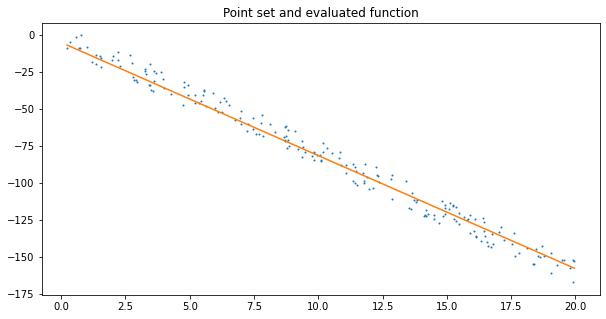



torch sgd result:
coeffs: [-7.488245  -6.9390454]
epoches: 36
loss: 0.18758928298950195


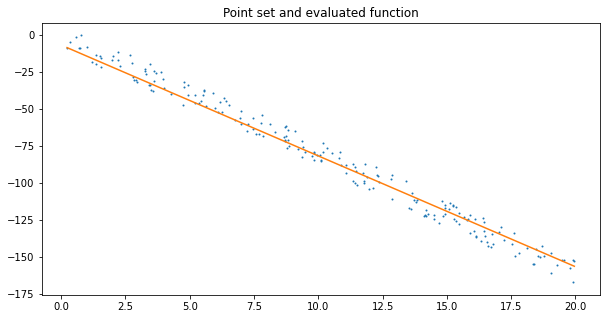

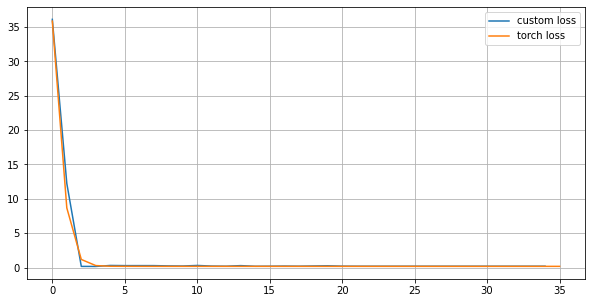

===large input===

custom sgd result:
coeffs: [-8.06096615 -4.24458052 -7.76144557 -4.50097986 -7.59887502 -7.43318458
 -6.19610454 -8.48643013 -7.74150178 -7.07211101]
epoches: 39
loss: 34.96367424448528


torch sgd result:
coeffs: [-6.2842355 -4.6115365 -5.9531345 -4.733526  -6.052138  -6.058563
 -5.4007487 -6.514832  -5.9300914 -5.920436 ]
epoches: 50
loss: 61.90607421875




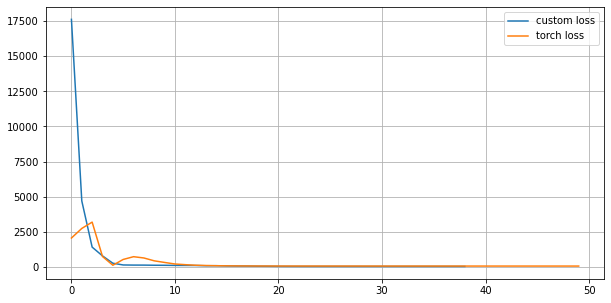

In [181]:
compare_sgd(input_2d, lambda model: torch.optim.RMSprop(model.parameters(), lr=1), rms_prop, 1, param_1=0.99)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.RMSprop(model.parameters(), lr=1.5, momentum=0.8), rms_prop, 1.5, param_1=0.8)

#### Adam

custom sgd result:
coeffs: [-8.45824524 -4.60224599]
epoches: 39
loss: 0.9649157811472757


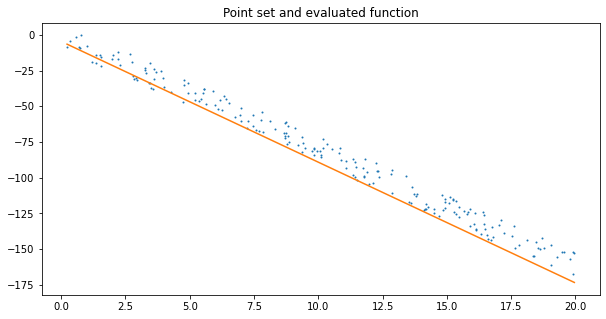



torch sgd result:
coeffs: [-4.5713496 -3.2270947]
epoches: 42
loss: 7.281459350585937


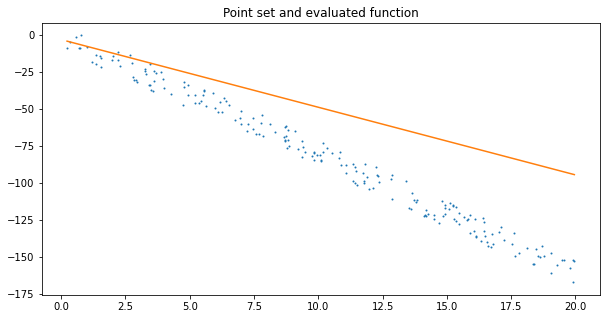

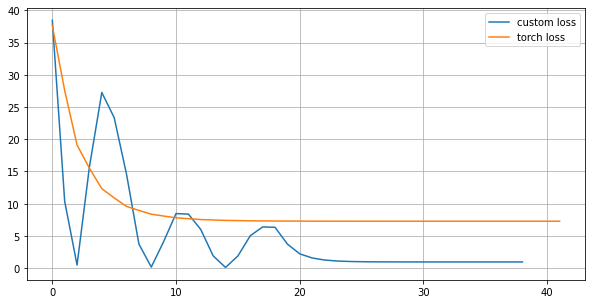

===large input===

custom sgd result:
coeffs: [-7.05933848 -6.12598496 -6.83668429 -6.53982078 -6.79919501 -6.89113647
 -6.61936301 -7.46671546 -7.05149362 -6.52025238]
epoches: 39
loss: 129.6714021175204


torch sgd result:
coeffs: [-3.962306  -3.8847935 -3.78729   -4.188844  -3.7263904 -4.010051
 -3.976417  -4.290908  -4.0321116 -3.6878746]
epoches: 44
loss: 361.4879296875




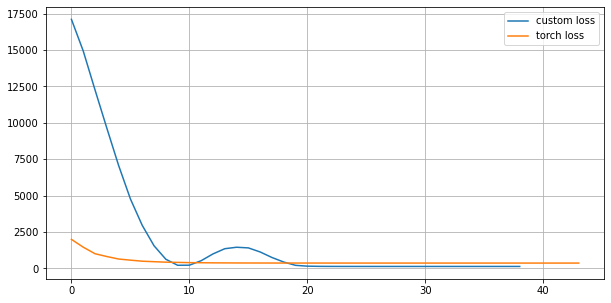

In [182]:
compare_sgd(input_2d, lambda model: torch.optim.Adam(model.parameters(), lr=1), adam, 1, param_1=0.9, param_2=0.999)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.Adam(model.parameters(), lr=1, betas=(0.8, 0.8)), adam, 1, param_1=0.8, param_2=0.8)

## Задание 3. SciPy

In [183]:
import torch
from math import *
from scipy.optimize import minimize, least_squares
from autograd import grad, jacobian
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from abc import abstractmethod
from numpy import matmul
import scipy
import scipy.optimize
from functools import partial

#### scipy.optimize.leas_squares

In [184]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def hess(f):
    J = jacobian(f)
    return 2 * J.T * J

  

 #### Gradient

In [185]:
start_x = [100., -3.]
print("sample")
print(minimize(rosenbrock, start_x))

sample
      fun: 6.721181929357622e-12
 hess_inv: array([[0.47353199, 0.94730229],
       [0.94730229, 1.90004656]])
      jac: array([-1.84562101e-07,  7.14712898e-06])
  message: 'Optimization terminated successfully.'
     nfev: 1509
      nit: 387
     njev: 503
   status: 0
  success: True
        x: array([1.00000258, 1.00000518])


In [186]:
def rosenbrock_with_grad(x):
    x = torch.tensor(x, requires_grad=True)
    res = rosenbrock(x)
    res.backward()
    return res.data.cpu().numpy(), x.grad.data.cpu().numpy()

print("with gradient")
print(minimize(rosenbrock_with_grad, start_x, jac=True))

with gradient
      fun: 1.4733648240102107e-14
 hess_inv: array([[0.49331477, 0.98754244],
       [0.98754244, 1.98176079]])
      jac: array([-4.30050809e-06,  2.08836317e-06])
  message: 'Optimization terminated successfully.'
     nfev: 486
      nit: 384
     njev: 486
   status: 0
  success: True
        x: array([0.99999994, 0.99999989])


In [187]:
print("with bounds")
print(minimize(rosenbrock, start_x, bounds = ((13, None), (-5, -2))))

with bounds
      fun: 2924244.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([889224.01983267, -34200.02779288])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([13., -2.])


#### Compare

In [188]:
class MatrixSolver:
    # compute gradinent of function f in point x with step h
    @staticmethod
    def grad(x, f, eps):
        derivative = np.zeros(np.size(x))
        for i in range(np.size(x)):
            x[i] += eps
            f1 = f(x)
            x[i] -= 2 * eps
            f2 = f(x)
            x[i] += eps
            derivative[i] = (f1 - f2) / (2 * eps)
        return derivative

    # compute Jacobian of functions rs = (r_1...r_n), r_i = r_i(x_1...x_m)
    @staticmethod
    def findJacobian(rs, x, eps):
        n = np.size(rs)
        m = np.size(x)
        J = np.zeros((n, m))
        for i in range(n):
            J[i] = MatrixSolver.grad(x, rs[i], eps)

        return J

    # compute pseudo inverse of matrix X
    @staticmethod
    def pseudoInverse(x):
        return np.linalg.inv(x.T @ x) @ x.T

    # compute hessian of functions R^n -> R
    @staticmethod
    def findHessian(func, x, eps):
        J = MatrixSolver.findJacobian(func, x, eps)
        return 2 * J.T @ J

In [189]:
class Searcher:
    def __init__(self, eps, max_iterations, func, start_x):
        self.eps = eps
        self.max_iterations = max_iterations
        self.func = func
        self.start_x = start_x

    # stop method
    def is_not_final(self):
        return LA.norm(self.next - self.cur_x) > self.eps and self.max_iterations >= self.epoch

    # draw plot
    def draw(self):
        # print("points:", self.points)

        min_point = self.points[-1]
        print("minimum:", min_point)
        
        repoints = np.asarray(self.points).reshape(-1, 2)
        pic = plt.figure(figsize=(10, 10))
        offset = max(np.max(repoints[:, 0]), abs(np.min(repoints[:, 0])))
        xs = np.linspace(min_point[0] - offset, min_point[0] + offset, 1000)

        plt.plot(xs, [self.func([x]) for x in xs])
        plt.plot(repoints[:, 0], repoints[:, 1], 'o-', color="red")
        plt.show()


    def save_point(self, x):
        self.points.append(np.append(x, self.func([x])))

    # executor method
    def run(self, drawing = 1):
        self.epoch = 2
        self.cur_x = self.start_x
        self.points = list()
        self.save_point(self.cur_x)
    
        self.next_point()
        while (self.is_not_final()):
            self.epoch += 1
            self.cur_x = self.next
            self.save_point(self.cur_x)
            self.next_point()

        self.save_point(self.next)
        print("argmin: ", self.next, "\nepoches: ", self.epoch, "\nnfev: ", self.epoch * 2)

        if drawing == 1:
            self.draw()


    # find next point
    @abstractmethod
    def next_point(self):
        pass

In [190]:
class Dogleg(Searcher):

    def __init__(self, eps, max_iteration, func, start_x,
                 initial_trust_radius=1.0, max_trust_radius=100.0, eta = 0.15):
        super().__init__(eps, max_iteration, func, start_x)
        self.initial_trust_radius = initial_trust_radius
        self.max_trust_radius = max_trust_radius
        self.eta = eta

    def find_shift(self):
        # find optimum
        optimum = -(np.linalg.inv(self.hess) @ self.jac)
        norm_opt = sqrt(optimum @ optimum)

        if norm_opt <= self.trust_radius:
            return optimum

        # find Cauchy point
        cauchy = - (self.jac @ self.jac / (self.jac @ (self.hess @ self.jac))) @ self.jac
        norm_cauchy = sqrt(cauchy @ cauchy)

        # stop in circul
        if norm_cauchy >= self.trust_radius:
            return self.trust_radius * cauchy / norm_cauchy

        tau = (self.trust_radius - cauchy) / (optimum - cauchy)

        return cauchy + tau * (optimum - cauchy)

    def find_trust_radius(self, shift):
        act_reduction = self.func(self.cur_x) - self.func(self.cur_x + shift)
        pred_reduction = -(self.jac @ shift + 0.5 * (shift @ (self.hess @ shift)))

        rho = act_reduction / pred_reduction
        if pred_reduction == 0.0:
            rho = 1e99

        norm_shift = sqrt(shift @ shift)

        if rho < 0.25:
            self.trust_radius = 0.25 * norm_shift
        else:
            if rho > 0.75 and norm_shift == self.trust_radius:
                self.trust_radius = min(2.0 * self.trust_radius, self.max_trust_radius)
            else:
                self.trust_radius = self.trust_radius


        if rho > self.eta:
            self.next = self.cur_x + shift
        else:
            # too close
            self.next = self.cur_x


    def next_point(self):
        self.jac = MatrixSolver.findJacobian([self.func], self.cur_x, self.eps)
        self.hess = MatrixSolver.findHessian([self.func], self.cur_x, self.eps)
        self.trust_radius = self.initial_trust_radius

        self.find_trust_radius(self.find_shift())


In [191]:
class GaussNewton(Searcher):

    def calculate(self, r, x):
        n = len(r)
        res = np.zeros(n)
        for i in range(n):
          res[i] = r[i](x)
        return res

    def get_function(self, r):
        return lambda x: self.calculate(r, x)

    def __init__(self, eps, max_iteration, rs, start_x):
        super().__init__(eps, max_iteration, self.get_function(rs), start_x)
        self.rs = rs

    def next_point(self):
        p = MatrixSolver.pseudoInverse(MatrixSolver.findJacobian(self.rs, self.cur_x, self.eps))
        #print(self.cur_x)
        self.next = self.cur_x - p @ self.func(self.cur_x)

In [192]:
class BFGS(Searcher):

    def __init__(self, eps, max_iteration, func, start_x, func_grad):
        super().__init__(eps, max_iteration, func, start_x)
        self.func_grad = func_grad
        self.H = np.eye(len(self.start_x), len(self.start_x))

    def next_H(self, y, s):
        I = np.eye(len(s), len(s)) # единичная матрица
        y_t = np.transpose(y)
        s_t = np.transpose(s)

        g= 1.0/(y_t @ s)
        g_s_y_T=g * (s @ y_t)
        g_y_s_t=g * (y @ s_t)
        return ((I-g_s_y_T) @ (self.H @ (I-g_y_s_t))) + g * (s @ s_t)


    def next_point(self):
        fgrad=MatrixSolver.grad(self.cur_x, self.func, self.eps)
        p = -self.H @ fgrad

        #находим alpha, которая подходит условиям вольфа
        alpha = scipy.optimize.line_search(self.func, self.func_grad , self.cur_x, p, c1=1e-4, c2=0.9) # ищем коэф, удовлетворяющий условию Вольфе
        if alpha[0] is None:
            s = 1e-4 * p
            print("None")
        else:
            s = alpha[0] * p
        
        
        # переход на следующую итерацию
        self.next = self.cur_x + s
        y=MatrixSolver.grad(self.next, self.func, self.eps)-fgrad
        self.H = self.next_H(y, s)

In [193]:
def f1(x):
    return sin(x[0]) + cos(x[0])

start_x = [1.1]

#### Dogleg

In [194]:
print("from scipy.least_squares")
print(least_squares(f1, start_x, method="dogbox", gtol=1e-5))


from scipy.least_squares
 active_mask: array([0])
        cost: 4.9476925258345e-19
         fun: array([9.947555e-10])
        grad: array([-1.40679672e-09])
         jac: array([[-1.41421356]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 4
        njev: 4
  optimality: 1.4067967214163938e-09
      status: 1
     success: True
           x: array([2.35619449])


In [195]:
print("from lab3")
Dogleg(1e-5, 1000, f1, np.array(start_x, float)).run(0)

from lab3
argmin:  [[3.75891924]] 
epoches:  7 
nfev:  14


In [196]:
def torch_f1(x):
    return torch.sin(x[0]) + torch.cos(x[0])

def f1_with_grad(x):
    x = torch.tensor(x, requires_grad=True)
    res = torch_f1(x)
    res.backward()
    return res.data.cpu().numpy(), x.grad.data.cpu().numpy()

In [197]:
print("from scipy.minimize")
print(minimize(f1_with_grad, start_x, method="Newton-CG", jac=True))

from scipy.minimize
     fun: -1.414213562373095
     jac: array([1.20963325e-05])
 message: 'Optimization terminated successfully.'
    nfev: 8
    nhev: 0
     nit: 3
    njev: 11
  status: 0
 success: True
       x: array([3.92699082])


In [198]:
print("from lab3")
GaussNewton(1e-5, 1000, [f1], np.array([1.1], float)).run(0)

from lab3
argmin:  [8.6393798] 
epoches:  7 
nfev:  14


#### BFGS

In [199]:
def grad_f1(x):
    return cos(x[0]) - sin(x[0])

In [200]:
print("from scipy.minimize")
print(minimize(f1_with_grad, start_x, method="BFGS", jac=True))

from scipy.minimize
      fun: -1.414213562373095
 hess_inv: array([[0.70712581]])
      jac: array([5.93774474e-10])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([10.21017612])


In [201]:
print("from lab3")
BFGS(1e-5, 1000, f1, np.array(start_x, float), grad_f1).run(0)

from lab3
argmin:  [3.92699082] 
epoches:  4 
nfev:  8
